In [1]:
import os
import collections
from math import log2
import numpy as np
import matplotlib.pyplot as plt
from tf.app import use

In [2]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

In [3]:
REPORT_DIR = os.path.expanduser("~/github/clariah/wp6-daghregisters/postocr/daghregister/004")

In [4]:
A = use("clariah/wp6-daghregisters:clone", checkout="clone", hoist=globals())

This is Text-Fabric 9.2.0
Api reference : https://annotation.github.io/text-fabric/tf/cheatsheet.html

13 features found and 0 ignored


In [44]:
CORPUS = tuple(F.letters.v(w) for w in range(1, F.otype.maxSlot + 1))

In [45]:
CORPUS_WORDS = tuple(word for word in CORPUS if not word.isdigit())

In [60]:
pieceFreqs = collections.Counter()
pieceFreqsPre = collections.Counter()
pieceFreqsPost = collections.Counter()

for word in CORPUS_WORDS:
    pieceFreqs[word] += 1
    for i in range(1, len(word)):
        pre = word[0:i]
        post = word[i:]
        pieceFreqsPre[pre] += 1
        pieceFreqsPost[post] += 1

In [71]:
wordSplits = {}

for word in set(CORPUS_WORDS):
    bestM = None
    if len(word) <= 3:
        continue
    (preBest, postBest) = (None, None)
    for i in range(2, len(word) - 1):
        pre = word[0:i]
        post = word[i:]
        m = log2((pieceFreqs[word] + pieceFreqsPre[word] + pieceFreqsPost[post]) / (pieceFreqsPre[pre] * pieceFreqsPost[post]))
        m *= len(pre) * len(post)
        if bestM is None or bestM > m:
            bestM = m
            (preBest, postBest) = (pre, post)
    wordSplits[word] = (preBest, postBest, bestM)

In [80]:
def showWord(word):
    if len(word) < 3:
        return
    bestM = None
    bestI = None
    splits = []
    for i in range(2, len(word) -1):
        pre = word[0:i]
        post = word[i:]
        m = log2((pieceFreqs[word] + pieceFreqsPre[word] + pieceFreqsPost[post]) / (pieceFreqsPre[pre] * pieceFreqsPost[post]))
        m *= len(pre) * len(post)
        splits.append((i, m))
        if bestM is None or bestM > m:
            bestM = m
            bestI = i
    for (i, m) in splits:
        isBest = "==>" if i == bestI else "   "
        pre = word[0:i]
        post = word[i:]
        print(f"{isBest} {m:7.2f} {pre:>20} {post:<20}")

In [81]:
showWord("achtervolcht")

    -138.73                   ac htervolcht          
    -172.13                  ach tervolcht           
    -202.88                 acht ervolcht            
==> -210.63                achte rvolcht             
    -204.58               achter volcht              
    -118.31              achterv olcht               
    -108.21             achtervo lcht                
     -93.33            achtervol cht                 
     -39.95           achtervolc ht                  


In [55]:
def printSplits():
    with open(f"{REPORT_DIR}/wordsplits.txt", "w") as fh:
        for (word, (pre, post, m)) in sorted(wordSplits.items(), key=lambda x: (-x[1][2], x[0])):
            fh.write(f"{word:<30} == {m:4.1f} => {pre:>20} {post:<20}\n")

In [78]:
printSplits()

In [13]:
def getFreqs(corpus):
    freqs = collections.Counter()

    for word in corpus[1:]:
        freqs[word] += 1
        
    return freqs

In [41]:
def printFreqs(corpus, fileName):
    freqs = getFreqs(corpus)
    with open(f"{REPORT_DIR}/{fileName}.tsv", "w") as fh:
        for (word, freq) in sorted(freqs.items(), key=lambda x: (-x[1], x[0])):
            fh.write(f"{word}\t{freq}\n")

In [34]:
def showWordFreqs(freqs):
    values = np.fromiter((log2(f) for f in freqs.values()), float)
    (frequency, bins) = np.histogram(values, bins=100)
    fig, ax = plt.subplots()
    ax.hist(values, bins=100)
    # ax.set(xticks=np.arange(-10, 20))
    plt.gca().set(title="Word frequencies", ylabel='Frequency')
    plt.show()

    nHapax = sum(1 for f in freqs.values() if f == 1)
    print(f"{len(freqs)} words of which {nHapax} are hapax")

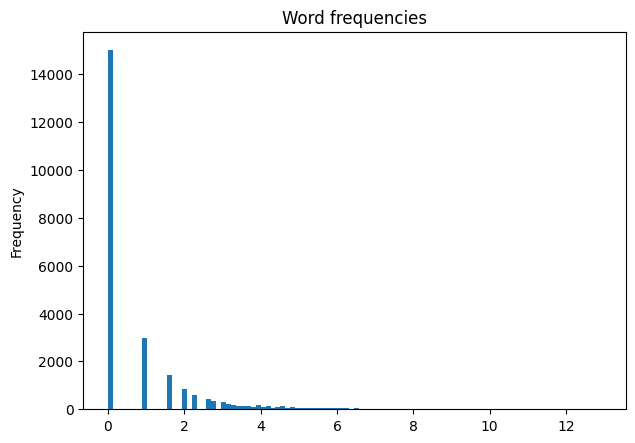

24626 words of which 15032 are hapax


In [35]:
showWordFreqs(getFreqs(CORPUS))

In [36]:
def splitup(corpus):
    freqs = getFreqs(corpus)
    wordSplits = collections.defaultdict(dict)

    allWords = sorted({word for word in corpus if not word.isdigit()})
    print(f"{len(allWords)} distinct words")

    for word in allWords:
        wn = len(word)
        if wn < 4:
            continue
        maxQ = None
        (word1Best, word2Best) = (None, None)
        for s in range(2, len(word) - 1):
            word1 = word[0:s]
            word2 = word[s:]

            word1C = freqs[word1]
            word2C = freqs[word2]
            if word1C < 3 or word2C < 3:
                continue
            q = (word1C - 1) * (word2C - 1)
            if q:
                if maxQ is None or maxQ < q:
                    maxQ = q
                    (word1Best, word2Best) = (word1, word2)
        if maxQ:
            wordSplits[word] = (word1Best, word2Best)

    print(f"{len(wordSplits)} word split candidates")
    
    newCorpus = []
    for word in corpus:
        if word.isdigit():
            continue
        newCorpus.extend(wordSplits.get(word, [word]))
    showWordFreqs(getFreqs(newCorpus))
    return newCorpus

Now we apply the splits: we make a new word array of all the words with composed words split into parts.

The idea is to repeat the procedure.

23761 distinct words
3009 word split candidates


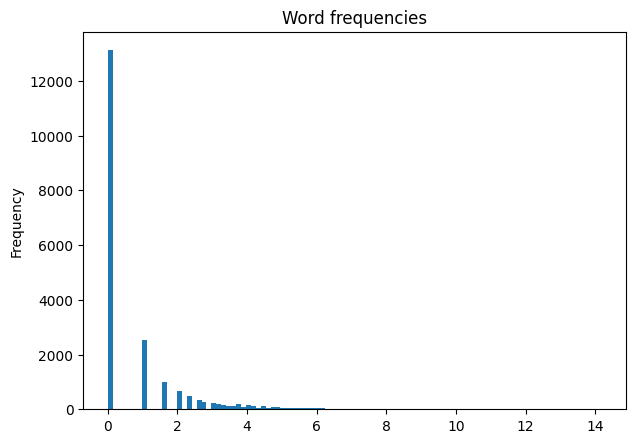

21022 words of which 13139 are hapax


In [37]:
CORPUS1 = splitup(CORPUS)

21010 distinct words
258 word split candidates


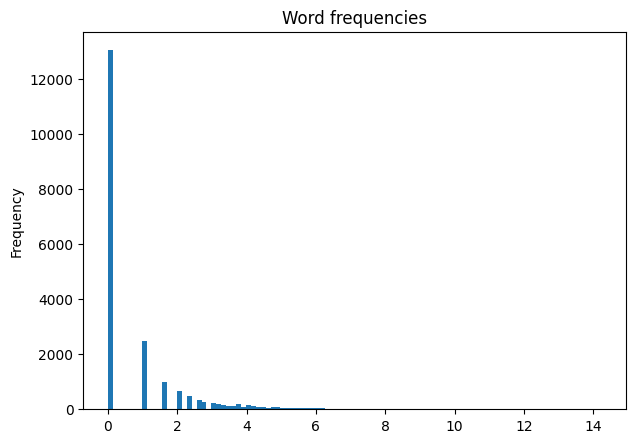

20777 words of which 13048 are hapax


In [38]:
CORPUS2 = splitup(CORPUS1)

20777 distinct words
25 word split candidates


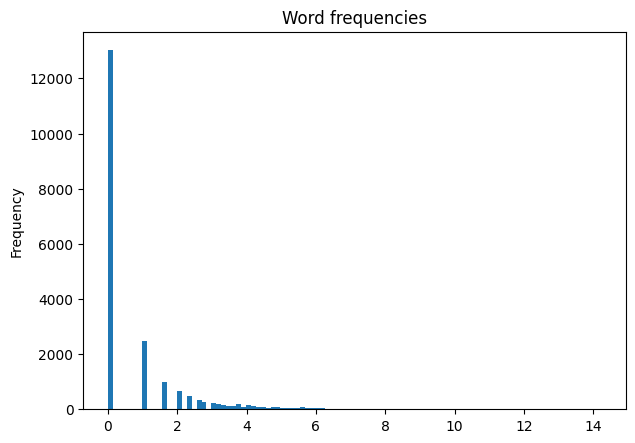

20753 words of which 13037 are hapax


In [39]:
CORPUS3 = splitup(CORPUS2)

In [42]:
printFreqs(CORPUS3, "corpus3")

freqs = getFreqs(CORPUS3)
hapaxes = sorted(word for word in CORPUS3 if freqs[word] == 1)

In [29]:
print("\n".join(hapaxes[0:100]))

!?•
!s
"/^
"/ie
"34
"\
"door
"ende
"hem
"is
"lasten
"rn
"vwlies
#
$omme
%0
&*
&*.
&^.
''S
'/
'/j
'/s
'Bantam
'Douta
'Ed
'Glaes
'Neederlanderen
'^
'^^^
'aleer
'bevroeden
'bisten
'by
'conde
'coopmanschappen
'daer
'dan
'de
'den
'die
'gebleven
'gecregen
'gelyck
'gepronunlieert
'had
'hadden
'hope
'k
'maer
'meede
'meer
'met
'nae
'omtrent
'peper
'quamen
'visite
'vreede
'waren
'weynich
))esettingh
*"
*).
*S
*V4
*♦
-'s
-2yde
-80
-[des
-cargasoen
-coopen
-dat
-de
-ende
-lont
-onecnicheyt
-te
-vande
.11
.3Vi
.Coninck
.Maart
.Mangsor
.Piscadores
.S4
.Samen
.^7
.ach
.anders
.committers
.cours
.datum
.de
.den
.die
.eenen
.macht
.niet


Now we try to peel of morphemes.

We look for common prefixes and suffixes, let's call them morfs.

We set a maximum length to morfs.

We split a word in a morf and a main if the quality of the split is high enough.

We define quality in rounds.

Round 0:

The quality of a main is the number of other morfs that can precede it. 
The empty morf also counts.

The quality of a morf is the average quality of the mains that can follow it.

In [44]:
MAX_MORF_SIZE = 5

QUALITY = {}

In [68]:
def getMorfSplits(corpus):
    words = set(corpus)
    mm = {False: {False: {}, True: {}}, True: {False: {}, True: {}}}
    for word in words:
        for i in range(1, min((MAX_MORF_SIZE + 1, len(word)))):
            morfPre = word[0:i]
            mainPost = word[i:]
            morfPost = word[-i:]
            mainPre = word[0:-i]
            mm[True][False].setdefault(morfPre, set()).add(mainPost)
            mm[False][True].setdefault(mainPost, set()).add(morfPre)
            mm[True][True].setdefault(morfPost, set()).add(mainPre)
            mm[False][False].setdefault(mainPre, set()).add(morfPost)
    return mm

In [69]:
MM = getMorfSplits(CORPUS3)

In [92]:
def getQuality(corpus, r):
    words = set(corpus)
    quality = {False: {False: {}, True: {}}, True: {False: {}, True: {}}}
    if r == 0:
        for where in (False, True):
            for (main, morfs) in MM[False][where].items():
                q = len(morfs)
                quality[False][where][main] = q if q < 6 else 12 - q if q < 12 else (0 if main in words else 1)
        for where in (False, True):
            for (morf, mains) in MM[True][where].items():
                quality[True][where][morf] = sum(quality[False][not where][main] for main in mains) * len(morf) * len(morf)
    return quality

In [93]:
QUALITY[0] = getQuality(CORPUS3, 0)

In [94]:
def printQuality(r):
    quality = QUALITY[r]
    for (what, kind) in ((False, "main"), (True, "morf")):
        for (where, fix) in ((False, "prefix"), (True, "suffix")):
            with open(f"{REPORT_DIR}/quality-{r}-{kind}-{fix}.tsv", "w") as fh:
                for (thing, q) in sorted(quality[what][where].items(), key=lambda x: (-x[1], x[0])):
                    fh.write(f"{thing}\t{q}\n")

In [95]:
printQuality(0)

In [81]:
MM[True][False]["Mour"]

{'lach'}

In [82]:
MM[False][True]["lach"]

{'Mour', 'afls', 'bec', 'miss', 'p', 's'}